## 1. Libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

#custom class
sys.path.append(os.path.abspath(os.path.join('..')))
from src.linear_regression_gd import LinearRegressionGD

## 2. Synthetic Data Generation

In [11]:
# Setup
np.random.seed(6)  # Ensures reproducibility
n_samples = 200

# GENERATING NUMERICAL FEATURES ----

# Rainfall: Normal Distribution (Mean=1200mm, Std=200mm)
rainfall = np.random.normal(1200, 200, n_samples)

# Fertilizer: Uniform Distribution (50 to 400 kg/ha)
fertilizer = np.random.uniform(50, 400, n_samples)

# Soil pH: Normal Distribution (Mean=6.5, Std=0.5)
ph_level = np.random.normal(6.5, 0.5, n_samples)


# GENERATING CATEGORICAL FEATURES ----

# Soil Type
soil_types = np.random.choice(['Loam', 'Clay', 'Sandy'], n_samples)

# Seed Variety
seed_varieties = np.random.choice(['Standard', 'Super_Hybrid', 'Drought_Resistant'], n_samples)


# DEFINING "GROUND TRUTH" (Target Generation) ----
# We define the exact weights the model should learn.

# Base Bias (Intercept)
true_bias = 2.0 

# Numerical Effects (True Weights)
y_simulated = true_bias + (0.003 * rainfall) + (0.015 * fertilizer) + (0.5 * ph_level)

# Categorical Effects (Simulating Dummy Weights)
soil_effects = pd.Series(soil_types).map({
    'Loam': 0,      # Baseline (Reference)
    'Clay': -0.5,
    'Sandy': -1.2
})

seed_effects = pd.Series(seed_varieties).map({
    'Standard': 0,           # Baseline (Reference)
    'Super_Hybrid': 1.5,
    'Drought_Resistant': 0.8
})

# Adding Random Noise
noise = np.random.normal(0, 0.5, n_samples) 

# Final Target Variable
y_final = y_simulated + soil_effects + seed_effects + noise

# DATAFRAME CREATION ---
df_synthetic = pd.DataFrame({
    'Rainfall_mm': rainfall,
    'Fertilizer_kg': fertilizer,
    'Soil_pH': ph_level,
    'Soil_Type': soil_types,
    'Seed_Variety': seed_varieties,
    'Yield_ton_ha': y_final
})

# Displaying dataset statistics to highlight scale differences
print("=== Synthetic Dataset Generated ===")
print("\nStatistics:")
print(df_synthetic.describe().round(2))

=== Synthetic Dataset Generated ===

Statistics:
       Rainfall_mm  Fertilizer_kg  Soil_pH  Yield_ton_ha
count       200.00         200.00   200.00        200.00
mean       1200.67         234.40     6.46         12.57
std         193.80         105.11     0.49          1.91
min         461.95          50.92     5.08          8.19
25%        1088.94         140.97     6.10         11.10
50%        1201.10         248.89     6.49         12.65
75%        1334.55         330.94     6.79         14.07
max        1726.26         399.37     7.62         17.36


## 3. Data Splitting, Model Training, and Evaluation

Training samples: 160
Testing samples:  40

Training in progress...
Training completed!

=== Model Performance on Test Set ===
RMSE: 0.4999 tons/ha
MAE:  0.3962 tons/ha
MAPE: 3.12 %
--------------------------------------------------
Interpretation: On average, the model error is 0.40 tons/ha.
This represents a percentage error of approximately 3.12% relative to actual yields.

--- Learned Weights (Feature Importance) ---
Bias (Intercept): 12.3883
                     Feature  Weight (Coefficient)
1              Fertilizer_kg              1.514207
0                Rainfall_mm              0.636101
5      Seed_Variety_Standard             -0.353167
2                    Soil_pH              0.339192
3             Soil_Type_Loam              0.278102
4            Soil_Type_Sandy             -0.268189
6  Seed_Variety_Super_Hybrid              0.229416


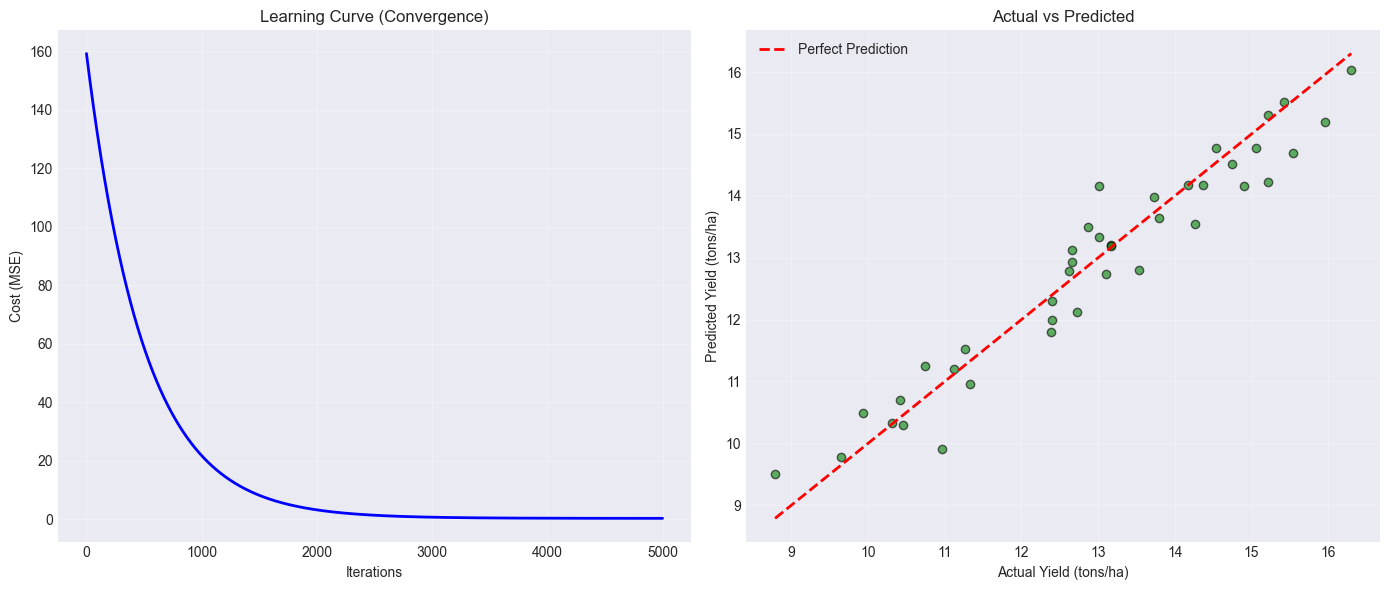

In [12]:
# Helper Function: Train-Test Split
def custom_train_test_split(X, y, test_size=0.2, random_seed=6):
    """
    Splits the dataset into training and testing sets.
    Replicates the functionality of sklearn.model_selection.train_test_split.
    """
    np.random.seed(random_seed)
    
    # Shuffle indices
    indices = np.random.permutation(len(X))
    
    # Calculate split index
    test_samples = int(len(X) * test_size)
    
    # Slice indices
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]
    
    return (X.iloc[train_indices], X.iloc[test_indices], 
            y.iloc[train_indices], y.iloc[test_indices])


# Define Features (X) and Target (y) using the synthetic dataframe
X = df_synthetic.drop('Yield_ton_ha', axis=1)
y = df_synthetic['Yield_ton_ha']

# Apply custom split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

# Model Training
# Normalization is enabled to handle the scale difference (e.g., Rainfall vs pH).
model = LinearRegressionGD(learning_rate=0.001, n_iterations=5000, normalize=True)

print("\nTraining in progress...")
model.fit(X_train, y_train)
print("Training completed!")

# Evaluation Metrics
predictions = model.predict(X_test)

# RMSE (Root Mean Squared Error)
mse = np.mean((y_test - predictions) ** 2)
rmse = np.sqrt(mse)

# MAE (Mean Absolute Error)
mae = np.mean(np.abs(y_test - predictions))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - predictions) / (y_test + 1e-10))) * 100

# PERFORMANCE REPORT ---
print(f"\n=== Model Performance on Test Set ===")
print(f"RMSE: {rmse:.4f} tons/ha")
print(f"MAE:  {mae:.4f} tons/ha")
print(f"MAPE: {mape:.2f} %")

print("-" * 50)
print(f"Interpretation: On average, the model error is {mae:.2f} tons/ha.")
print(f"This represents a percentage error of approximately {mape:.2f}% relative to actual yields.")

# Feature Importance (Learned Weights)
weights_df = pd.DataFrame({
    'Feature': model.training_columns,
    'Weight (Coefficient)': model.weights
})

# Sort by absolute impact to identify most influential factors
weights_df['Abs_Impact'] = weights_df['Weight (Coefficient)'].abs()
weights_df = weights_df.sort_values(by='Abs_Impact', ascending=False)

print("\n--- Learned Weights (Feature Importance) ---")
print(f"Bias (Intercept): {model.bias:.4f}")
print(weights_df[['Feature', 'Weight (Coefficient)']])

# Visualization
plt.figure(figsize=(14, 6))

# Plot 1: Learning Curve
plt.subplot(1, 2, 1)
plt.plot(model.cost_history, color='blue', linewidth=2)
plt.title('Learning Curve (Convergence)')
plt.xlabel('Iterations')
plt.ylabel('Cost (MSE)')
plt.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.6, color='green', edgecolors='k')

# Identity Line (Perfect Prediction)
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Yield (tons/ha)')
plt.ylabel('Predicted Yield (tons/ha)')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Custom Model vs. Scikit-Learn

**Note:** Since the custom class (`LinearRegressionGD`) handles One-Hot Encoding and Feature Scaling internally, we must **manually replicate** these preprocessing steps for Scikit-Learn to ensure a mathematically fair comparison.


METRIC     | CUSTOM MODEL         | SCIKIT-LEARN         | DIFFERENCE     
---------------------------------------------------------------------------
RMSE       | 0.49990              | 0.49174              | 0.00815        
MAE        | 0.39622              | 0.39833              | 0.00211        
MAPE (%)   | 3.1157               | 3.1730               | 0.0573         
---------------------------------------------------------------------------

The results are statistically identical.
The custom Gradient Descent implementation matches the OLS industry standard.
Final Error (MAPE): 3.12%


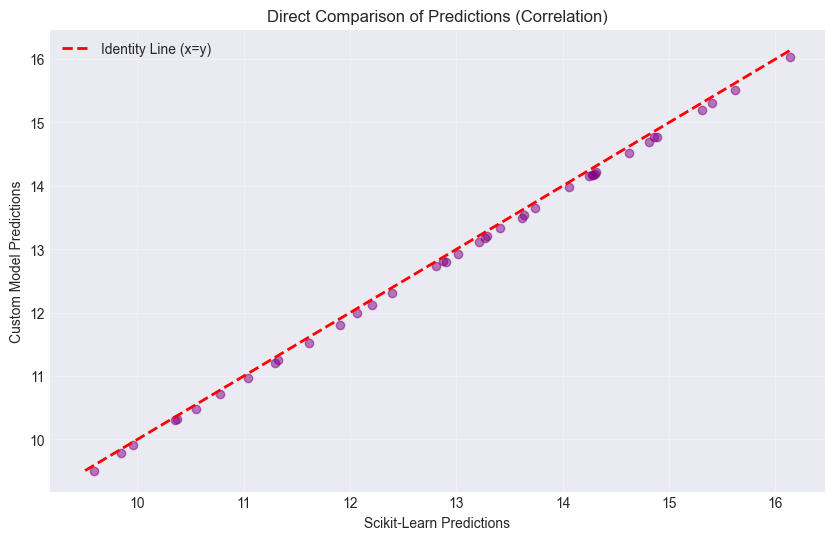

In [13]:

# PREPROCESSING FOR SCIKIT-LEARN ----

# One-Hot Encoding
X_train_sklearn = pd.get_dummies(X_train, drop_first=True, dtype=float)
X_test_sklearn = pd.get_dummies(X_test, drop_first=True, dtype=float)

# Column Alignment
model_cols = model.training_columns 
X_train_sklearn = X_train_sklearn.reindex(columns=model_cols, fill_value=0)
X_test_sklearn = X_test_sklearn.reindex(columns=model_cols, fill_value=0)

# Feature Scaling
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_sklearn)
X_test_final = scaler.transform(X_test_sklearn)


# TRAINING ----

# Scikit-Learn
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_final, y_train)

# Custom Class: Already trained in the 'model' variable (Uses Gradient Descent)


# PREDICTION & METRICS COMPARISON ----

# Generate Predictions
preds_custom = model.predict(X_test)     
preds_sklearn = sklearn_model.predict(X_test_final)


# CALCULATING METRICS -----

# RMSE (Root Mean Squared Error)
rmse_custom = np.sqrt(mean_squared_error(y_test, preds_custom))
rmse_sklearn = np.sqrt(mean_squared_error(y_test, preds_sklearn))

# MAE (Mean Absolute Error)
mae_custom = mean_absolute_error(y_test, preds_custom)
mae_sklearn = mean_absolute_error(y_test, preds_sklearn)

# MAPE (Mean Absolute Percentage Error)
mape_custom = np.mean(np.abs((y_test - preds_custom) / (y_test + 1e-10))) * 100
mape_sklearn = np.mean(np.abs((y_test - preds_sklearn) / (y_test + 1e-10))) * 100


# COMPARISON TABLE ----
print(f"\n{'METRIC':<10} | {'CUSTOM MODEL':<20} | {'SCIKIT-LEARN':<20} | {'DIFFERENCE':<15}")
print("-" * 75)

# RMSE
diff_rmse = abs(rmse_custom - rmse_sklearn)
print(f"{'RMSE':<10} | {rmse_custom:<20.5f} | {rmse_sklearn:<20.5f} | {diff_rmse:<15.5f}")

# MAE
diff_mae = abs(mae_custom - mae_sklearn)
print(f"{'MAE':<10} | {mae_custom:<20.5f} | {mae_sklearn:<20.5f} | {diff_mae:<15.5f}")

# MAPE
diff_mape = abs(mape_custom - mape_sklearn)
print(f"{'MAPE (%)':<10} | {mape_custom:<20.4f} | {mape_sklearn:<20.4f} | {diff_mape:<15.4f}")

print("-" * 75)


# FINAL RESULTS ----

if diff_rmse < 0.05:
    print(f"\nThe results are statistically identical.")
    print(f"The custom Gradient Descent implementation matches the OLS industry standard.")
    print(f"Final Error (MAPE): {mape_custom:.2f}%")
else:
    print(f"\n⚠️ DIVERGENCE DETECTED. Check learning_rate or iteration count.")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(preds_sklearn, preds_custom, alpha=0.5, color='purple')

# Identity Line (x=y)
min_val = min(preds_sklearn.min(), preds_custom.min())
max_val = max(preds_sklearn.max(), preds_custom.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Identity Line (x=y)')

plt.xlabel('Scikit-Learn Predictions')
plt.ylabel('Custom Model Predictions')
plt.title(f'Direct Comparison of Predictions (Correlation)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Final Visualizations

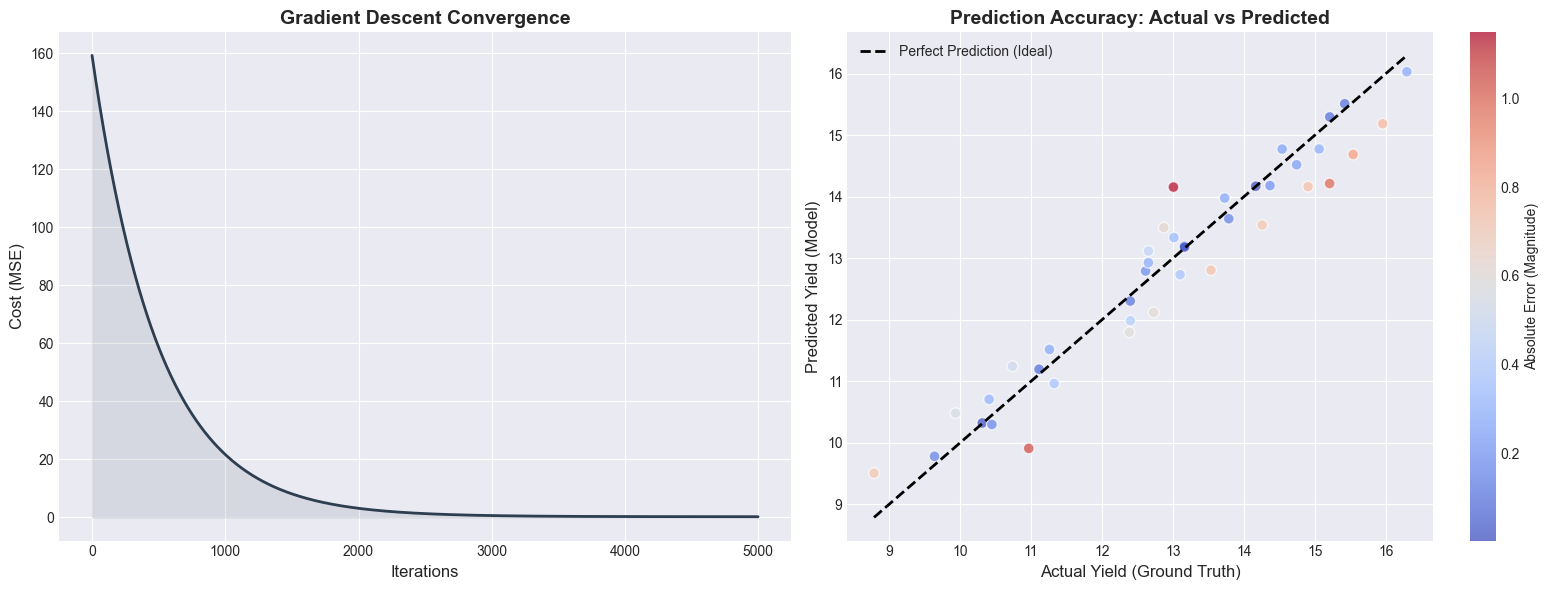

In [14]:
# Style Configuration
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Learning Curve ---
ax1.plot(model.cost_history, color='#2c3e50', linewidth=2)
ax1.fill_between(range(len(model.cost_history)), model.cost_history, color='#2c3e50', alpha=0.1)
ax1.set_title('Gradient Descent Convergence', fontsize=14, fontweight='bold')
ax1.set_xlabel('Iterations', fontsize=12)
ax1.set_ylabel('Cost (MSE)', fontsize=12)

# annotation
# ax1.text(len(model.cost_history)*0.5, max(model.cost_history)*0.5, 
#          'Smooth Convergence\n(No Oscillations)', 
#          fontsize=12, color='green', ha='center', bbox=dict(facecolor='white', alpha=0.8))

# Plot 2: Prediction vs Actual (With Error Heatmap) ---
# Calculating absolute error for point coloring
errors = np.abs(y_test - predictions)
sc = ax2.scatter(y_test, predictions, c=errors, cmap='coolwarm', alpha=0.7, edgecolors='w', s=60)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Absolute Error (Magnitude)')

# Perfect Prediction Line (Ideal Scenario)
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction (Ideal)')

ax2.set_title('Prediction Accuracy: Actual vs Predicted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Actual Yield (Ground Truth)', fontsize=12)
ax2.set_ylabel('Predicted Yield (Model)', fontsize=12)
ax2.legend()

plt.tight_layout()

# Saving the figure
plt.savefig(os.path.join('..', 'img', 'scenario1_accuracy_dashboard.png'), dpi=300)
plt.show()